<a href="https://colab.research.google.com/github/Gedionir/Metricas_avaliacao_classificacao_dados/blob/main/Matriz_de_Confus%C3%A3o(Diagn%C3%B3stico_do_C%C3%A2ncer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

np.random.seed(42)
sns.set(rc={"figure.figsize": (8, 8)})
sns.set_style("ticks")

In [68]:
data = load_breast_cancer()
print(data.DESCR[:760])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline appr


In [69]:
print(f"Tipos de cancer são {data.target_names}")

Tipos de cancer são ['malignant' 'benign']


In [70]:
X = data.data  # features (características)
y = data.target  # labels (rótulos)
print(f"Shape of features is {X.shape}, and shape of target is {y.shape}")

Shape of features is (569, 30), and shape of target is (569,)


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=42, stratify=y)
y_train[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 0, 1])

In [72]:
classifier = svm.SVC(kernel='linear', probability=True, verbose=True)
classifier.fit(X_train, y_train)

[LibSVM]

SVC(kernel='linear', probability=True, verbose=True)

In [73]:
y_preds = classifier.predict(X_test)
y_proba = classifier.predict_proba(X_test)

In [74]:
y_proba = y_proba[:,1].reshape((y_proba.shape[0],))
y_proba[:5], y_preds[:5], y_test[:5]

(array([0.99697262, 0.08136644, 0.99999168, 0.96809392, 0.99999907]),
 array([1, 0, 1, 1, 1]),
 array([1, 0, 1, 1, 1]))

##MATRIZ DE CONFUSÃO

In [75]:
conf = metrics.confusion_matrix(y_test, y_preds)
conf

array([[ 68,   7],
       [  2, 123]])

In [76]:
def get_confusion_matrix(y_true, y_pred):
    n_classes = len(np.unique(y_true))
    conf = np.zeros((n_classes, n_classes))
    for actual, pred in zip(y_true, y_pred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

In [77]:
conf = get_confusion_matrix(y_test, y_preds)
conf

array([[ 68,   7],
       [  2, 123]])

Text(0.5, 114.24999999999993, 'Predicted label')

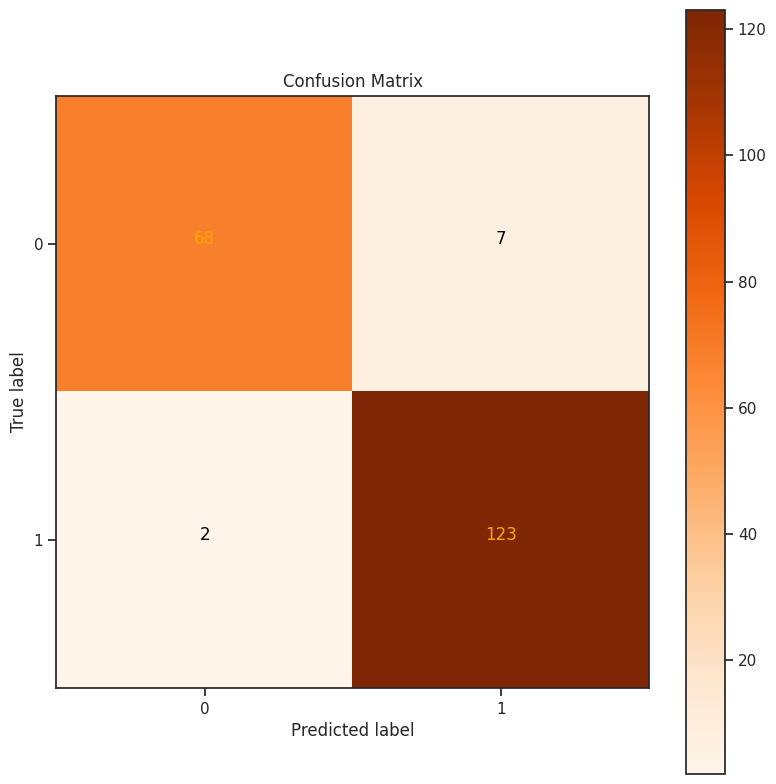

In [78]:
classes = [0, 1]
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="orange" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

###Em uma matriz de confusão podemos obter números de 'Verdadeiros Positivos', 'Verdadeiros Negativos', 'Falso Postivos' e 'Falso Negativos'. Agora vamos armazenar esses termos nas variáveis.

In [79]:
VP = true_pos = 123
VN = true_neg = 68
FP = false_pos = 7
FN = false_neg = 2
N = VP + VN + FP + FN

results = {}

###Accuracy (Acurácia).
Precisão ou Acurácia:
Número de exemplos previstos corretamente / número total de exemplos.

In [80]:
metric = "ACC"
results[metric] = (VP + VN) / N
print(f"{metric} is {results[metric]: .3f}")

ACC is  0.955


###Sensitivity (Sensibilidade).
Taxa Verdadeiramente Positiva
número de amostras reais e previstas como `Positivas` / número total de amostras realmente `Positivas`
Também chamado de **Sensibilidade ou Rechamada**.

In [81]:
metric = "TPR"
results[metric] = VP / (VP + VN)
print(f"{metric} is {results[metric]: .3f}")

TPR is  0.644


###Specifity (Especificidade).
Taxa Verdadeiramente Negativa
número de amostras reais e previstas como `Negativas` / número total de amostras realmente `Negativas`
Também chamada de **Especificidade**.

In [82]:
metric = "TNR"
results[metric] = VN / (VN + FP)
print(f"{metric} is {results[metric]: .3f}")

TNR is  0.907


###Precision (Precisão).
Valor Preditivo Positivo
número de amostras realmente previstas como `Positivas` / número total de amostras previstas como `Positivas`
Também chamada de **Precisão**.

In [83]:
metric = "PPV"
results[metric] = VP / (VP + FP)
print(f"{metric} is {results[metric]: .3f}")

PPV is  0.946


###F1 Score.

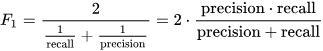

In [84]:
metric = "F1"
results[metric] = 2 / (1 / results["PPV"] + 1 / results["TPR"])
print(f"{metric} is {results[metric]: .3f}")

F1 is  0.766


### Curva de ROC (curva característica de operação do receptor)

In [85]:
def get_roc_curve(y_test, y_proba, delta=0.1):
    """
    Retorne as taxas de verdadeiros positivos (TPRs), taxas de falsos positivos (FPRs),
    e os valores limite, separados por delta.
    """
    thresh = list(np.arange(0, 1, delta)) + [1]
    TPRs = []
    FPRs = []
    y_pred = np.empty(y_proba.shape)
    for th in thresh:
        y_pred[y_proba < th] = 0
        y_pred[y_proba >= th] = 1

        (TN, FP), (FN, TP) = get_confusion_matrix(y_test, y_pred)

        TPR = TP / (TP + FN)  # sensibilidade
        FPR = FP / (FP + TN)  # especificidade
        TPRs.append(TPR)
        FPRs.append(FPR)
    return FPRs, TPRs, thresh

In [86]:
delta = 0.001
FPRs, TPRs, _ = get_roc_curve(y_test, y_proba, delta)

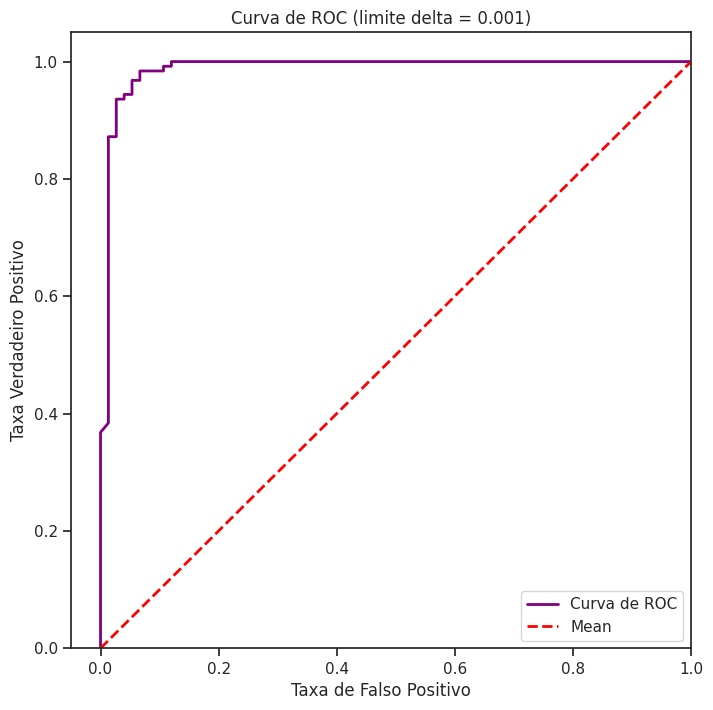

In [87]:
# Plotando a curva de ROC
plt.plot(FPRs, TPRs, color='Purple',
         lw=2, label='Curva de ROC')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa Verdadeiro Positivo')
plt.title(f'Curva de ROC (limite delta = {delta})')
plt.legend(loc="lower right")
plt.show()